In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../analysis/

/home/jlee782/hcomp_paper_seg/analysis


In [3]:
from spectral_clustering import *
from PixelEM import *

/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/jlee782/.local/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [48]:
clust_df = pd.read_csv("spectral_clustering_all_hard_obj.csv")

In [51]:
sample_name = "15workers_rand0"
objid = 41
cluster_id=1
PLOT=False
PRINT=False
EXCLUDE_BBG=True
worker_ids=[]

In [129]:
def create_mega_mask(objid, cluster_id="", PLOT=False, sample_name='5workers_rand0', PRINT=False, EXCLUDE_BBG=True):
    img_info, object_tbl, bb_info, hit_info = load_info()
    # bb_info is the set of all workers that annotated object i
    bb_objects = bb_info[bb_info["object_id"] == objid]
    if cluster_id=="" or cluster_id=="-1" or cluster_id==-1:
        outdir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, sample_name, objid)
    else:
        outdir = '{}{}/obj{}/clust{}/'.format(PIXEL_EM_DIR, sample_name, objid, cluster_id)
    if EXCLUDE_BBG:
        bb_objects = bb_objects[bb_objects.worker_id != 3]
    if not os.path.isdir(outdir):
        os.makedirs(outdir)

    sampleNworkers = sample_specs[sample_name][0]
    if sampleNworkers > 0 and sampleNworkers < len(bb_objects):
        bb_objects = bb_objects.sample(n=sample_specs[sample_name][0], random_state=sample_specs[sample_name][1])
    worker_ids_in_sample = list(bb_objects["worker_id"])
    if cluster_id=="" or cluster_id=="-1" or cluster_id==-1:
        # For the no cluster cases, sampling data from table 
        worker_ids= worker_ids_in_sample
    else:
        clust_df = pd.read_csv("spectral_clustering_all_hard_obj.csv")
        worker_ids_in_cluster = list(clust_df[(clust_df["objid"]==objid)&(clust_df["cluster"]==cluster_id)]["wid"])
        worker_ids_in_cluster= set(worker_ids_in_cluster)
        worker_ids_in_sample = set(worker_ids_in_sample)
        worker_ids = list(worker_ids_in_cluster.intersection(worker_ids_in_sample))
    with open('{}worker_ids.json'.format(outdir), 'w') as fp:
        fp.write(json.dumps(worker_ids))
    # Megamask creation
    img_name = img_info[img_info.id == int(object_tbl[object_tbl.id == objid]["image_id"])]["filename"].iloc[0]
    fname = ORIGINAL_IMG_DIR + img_name + ".png"
    width, height = get_size(fname)
    mega_mask = np.zeros((height, width))
    voted_workers_mask = np.zeros((height, width), dtype=object)

    for wid in worker_ids:
        mask = get_worker_mask(objid, wid)
        mega_mask += mask
        # Voted Mask
        voted_coord = np.where(mask == True)
        for x, y in zip(voted_coord[0], voted_coord[1]):
            if voted_workers_mask[x, y] == 0:
                voted_workers_mask[x, y] = [wid]
            else:
                voted_workers_mask[x, y].append(wid)

    if PLOT:
        # Visualize mega_mask
        plt.figure()
        plt.imshow(mega_mask, interpolation="none")  # ,cmap="rainbow")
        # plt.imshow(mask, interpolation="none")  # ,cmap="rainbow")
        plt.colorbar()
        #plt.savefig('{}mega_mask.png'.format(outdir))
    with open('{}mega_mask.pkl'.format(outdir), 'w') as fp:
        fp.write(pickle.dumps(mega_mask))
    with open('{}voted_workers_mask.pkl'.format(outdir), 'w') as fp:
        fp.write(pickle.dumps(voted_workers_mask))

In [115]:
print worker_ids_in_cluster
print worker_ids_in_sample
print worker_ids

set([192, 161, 131, 260, 135, 140, 240, 147, 148, 118, 184, 250])
set([68, 260, 133, 135, 9, 234, 240, 147, 148, 181, 214, 196, 219, 156, 213])
[240, 148, 147, 260, 135]


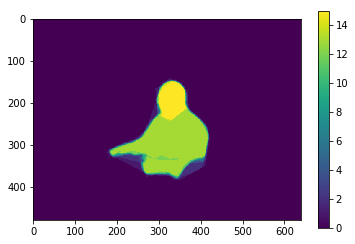

In [125]:
create_mega_mask(1, cluster_id=-1, PLOT=True, sample_name = "15workers_rand0")

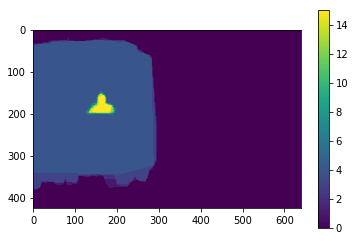

In [126]:
create_mega_mask(40, cluster_id=-1, PLOT=True, sample_name = "15workers_rand0")

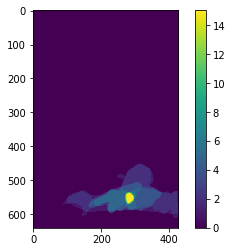

In [127]:
create_mega_mask(41, cluster_id=-1, PLOT=True, sample_name = "15workers_rand0")

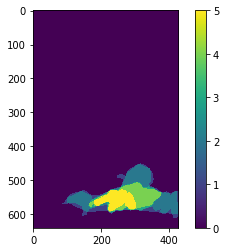

In [128]:
create_mega_mask(41, cluster_id=1, PLOT=True, sample_name = "15workers_rand0")

In [135]:
cat pixel_em/25workers_rand0/obj18/worker_ids.json

[114, 225, 196, 172, 208, 6, 187, 203, 201, 181, 194, 82, 211, 217, 199, 256, 33, 175, 32, 219, 205, 200, 116, 54, 209]

In [136]:
cat pixel_em/25workers_rand0/obj18/clust0/worker_ids.json

[256, 6, 32, 33, 172, 175, 181, 54, 194, 196, 199, 200, 201, 203, 205, 208, 209, 211, 217, 219, 225, 114, 116]

In [137]:
cat pixel_em/25workers_rand0/obj18/clust1/worker_ids.json

[82, 187]

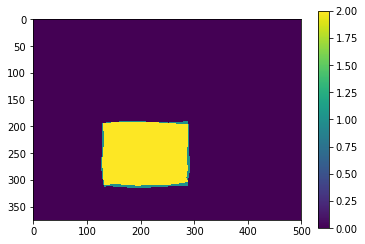

In [133]:
m = pkl.load(open("pixel_em/25workers_rand0/obj18/clust1/mega_mask.pkl"))
plt.imshow(m)
plt.colorbar()

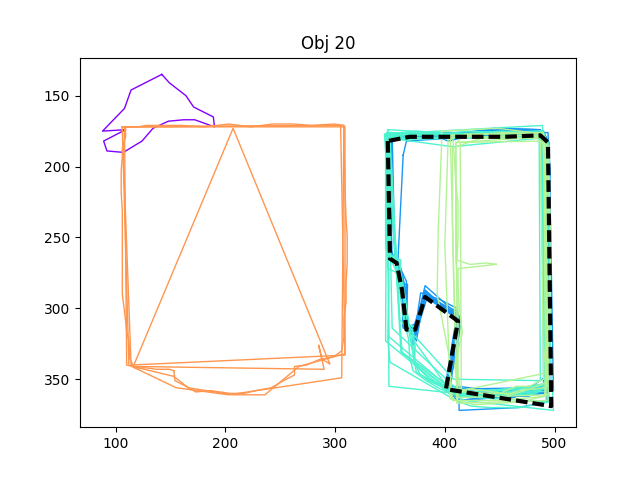

In [130]:
from IPython.display import display
from PIL import Image

display(Image.open("cluster_img/20.png"))